In [1]:
from typing import Optional
import torch


torch.manual_seed(456)
torch.cuda.manual_seed(456)

import torch.nn as nn
import torch.nn.functional as F
import open_clip


from src.augmix import (
    AugMixKornia,
    ImageTransform,
    kornia_preprocess,
    kornia_random_crop,
)
from src.data import ImagenetA
from src.utils import bench
import matplotlib.pyplot as plt
import numpy as np

/home/ettore/.conda/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging

logging.basicConfig(level=logging.INFO)


def plot_image_grid(images, title, ncols=4):
    """
    Plot a grid of images.

    Args:
        images: Tensor or numpy array of shape (N, C, H, W) or (N, H, W, C)
        title: Title for the entire figure
        ncols: Number of columns in the grid
    """
    # Convert to numpy and handle channel dimension
    if not isinstance(images, np.ndarray):
        images = images.cpu().numpy().astype(np.float32)

    # Handle (N, C, H, W) -> (N, H, W, C) if needed
    if images.shape[1] in [1, 3]:  # Assuming 1 or 3 channels
        images = images.transpose(0, 2, 3, 1)

    n_images = images.shape[0]
    nrows = int(np.ceil(n_images / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < n_images:
            ax.imshow(images[i])
            ax.set_title(f"Image {i + 1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

augmenter = ImageTransform(
    model_transform=kornia_preprocess,
    custom_transform=kornia_random_crop,
    n_views=63,
    device="cpu",
)

dataloader, dataset = ImagenetA(augmenter, num_workers=6)

# Load the CLIP model
clip_model, _, _ = open_clip.create_model_and_transforms(
    # model_name="ViT-B-32", pretrained="datacomp_xl_s13b_b90k", device=device#, force_quick_gelu=True
    model_name="ViT-B-16",
    pretrained="openai",
    device=device,
    force_quick_gelu=True,
)
clip_model.eval()  # type: ignore
clip_model.visual.output_tokens = True  # type: ignore

INFO:root:Loaded ViT-B-16 model config.
INFO:root:Loading pretrained ViT-B-16 weights (openai).


In [ ]:
class ClipWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        class_labels: dict,
        prompt: str = "a photo of a {}",
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device

        self.tokenizer = open_clip.get_tokenizer("ViT-B-16")
        self.model: open_clip.model.CLIP = model
        self.logit_scale = model.logit_scale.data.exp()
        # self.logit_scale = model.log

        with torch.no_grad():
            prompts = torch.cat(
                [self.tokenizer(prompt.format(c)) for c in class_labels.values()]
            ).to(device)
            self.text_features = model.encode_text(prompts, normalize=True)

    def select_confident_samples(
        self, logits: torch.Tensor, top: float = 0.1
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Selects the top-k samples with the lowest entropy from the logits.

        Args:
            logits (torch.Tensor): The logits from the model.
            top (float): The fraction of samples to select.
                For example, if top=0.1, it selects the top 10% of samples.
        Returns:
            torch.Tensor: The selected logits.
            torch.Tensor: The indices of the selected samples.

        [Reference](https://github.com/azshue/TPT/blob/63ecbace79694205d7884e63fdc3137a200f0b0e/tpt_classification.py#L41C5-L41C11)
        """
        batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
        idx = torch.argsort(batch_entropy, descending=False)[
            : int(batch_entropy.size()[0] * top)
        ]

        return logits[idx], idx

    def forward(self, x: torch.Tensor) -> int:
        with torch.no_grad():  # , torch.autocast("cuda"):
            clip_model.visual.output_tokens = True  # type: ignore

            # Patch embedding: (batch_size, num_patches + 1, embed_dim)
            # on 224x224 images: [1, 50, 768]
            image_features, tokens = self.model.visual(x)

            image_features = F.normalize(image_features, dim=-1)

            filtered_logits = (
                self.logit_scale * image_features[:-1:] @ self.text_features.T
            )

            selected_logits, idx = self.select_confident_samples(
                logits=filtered_logits, top=0.1
            )

            # selected_tokens = torch.cat((tokens[idx], tokens[-1:]), dim=0) # semplice
            selected_tokens = tokens[idx]  # coso_separato

            # Calcualte PCA (n_components=1) of each of the selected tokens
            # Assuming patch_embeddings is a tensor of shape [64, 50, 768]
            batch_size, num_patches, feat_dim = selected_tokens.shape
            PATCH_RES = int(num_patches**0.5)  # Assuming num_patches is a square number

            # Center the data (subtract mean)
            patch_embeddings_centered = selected_tokens - selected_tokens.mean(
                dim=1, keepdim=True
            )

            U, S, V = torch.pca_lowrank(patch_embeddings_centered, q=1, center=False)

            # Project the data (get the first principal component scores)
            fg_scores = torch.matmul(
                patch_embeddings_centered, V[:, :, -1:]
            )  # [64, 50, 1]

            # Min-max scaling per image
            min_vals = fg_scores.min(dim=1, keepdim=True)[0]
            max_vals = fg_scores.max(dim=1, keepdim=True)[0]
            fg_scores_scaled = (fg_scores - min_vals) / (
                max_vals - min_vals + 1e-8
            )  # [64, 50, 1]

            # Reshape to [64, PATCH_RES, PATCH_RES]
            fg_scores_reshaped = fg_scores_scaled.view(batch_size, PATCH_RES, PATCH_RES)

            # Create mask
            positive_mask = fg_scores_reshaped > 0.6
            # negative_mask = fg_scores_reshaped < 0.4

            # print(
            #     f"mask shape: {positive_mask.shape}    fg_scores shape: {fg_scores.shape}"
            # )

            # Apply mask on the input (x) on the specific indices
            positive_masked = x[idx].clone()
            # positive_masked = torch.cat((positive_masked, x[-1:]), dim=0) # Semplice
            negative_masked = positive_masked.clone()

            positive_mask = F.interpolate(
                positive_mask.unsqueeze(1).float(),  # Add channel dimension
                size=(x.shape[2], x.shape[3]),  # Resize to input image size
                mode="nearest",
            )

            # negative_mask = F.interpolate(
            #     negative_mask.unsqueeze(1).float(),  # Add channel dimension
            #     size=(x.shape[2], x.shape[3]),  # Resize to input image size
            #     mode="nearest",
            # )

            positive_masked = positive_masked * positive_mask  # .bool()
            negative_masked = negative_masked * (1 - positive_mask)  # .bool()

            # # visualize the original image
            # plt.imshow(x[-1].cpu().numpy().transpose(1, 2, 0))
            # plt.title("Original Image")
            # plt.axis("off")
            # plt.show()

            # # for i in range(positive_masked.shape[0]):
            # #     img = positive_masked[i].cpu().numpy().transpose(1, 2, 0)
            # #     plt.imshow(img)
            # #     plt.title(f"Masked Image {i + 1}")
            # #     plt.axis("off")
            # #     plt.show()

            # plot_image_grid(positive_masked, "Positive Masked Images")
            # plot_image_grid(negative_masked, "Negative Masked Images")
            # plot_image_grid(torch.cat((x[idx], x[-1:]), dim=0), "Original")

            # # Calculate the logits for the positive and negative masked images
            clip_model.visual.output_tokens = False  # type: ignore

            pos_logits = self.model.encode_image(positive_masked, normalize=True)
            neg_logits = self.model.encode_image(negative_masked, normalize=True)
            # orig_logits = F.normalize(selected_logits, dim=-1)

            # # # pos_logits = torch.cat(
            # # #     (pos_logits, image_features[-1:]), dim=0
            # # # )  # coso_separato
            # # # neg_logits = torch.cat(
            # # #     (neg_logits, image_features[-1:]), dim=0
            # # # )  # coso_separato

            # # # # # Calculate the cosine similarity between the positive and negative logits
            # # # pos_logits = pos_logits @ self.text_features.T * self.logit_scale
            # # # neg_logits = neg_logits @ self.text_features.T * self.logit_scale
            # # # # orig_logits = orig_logits @ self.text_features.T * self.logit_scale

            # # # pos_marginal_prob = F.softmax(pos_logits, dim=1).mean(0)
            # # # neg_marginal_prob = F.softmax(neg_logits, dim=1).mean(0)

            # # # # # Get the logits with the highest average confidence

            # # # if pos_marginal_prob.max() > neg_marginal_prob.max():
            # # #     pred_class = pos_marginal_prob.argmax().item()
            # # # else:
            # # #     pred_class = neg_marginal_prob.argmax().item()

            logits = torch.cat((pos_logits, neg_logits, image_features[-1:]), dim=0)
            logits = logits @ self.text_features.T * self.logit_scale

            logits = self.select_confident_samples(logits, top=0.1)[0]

            marginal_prob = F.softmax(logits, dim=1).mean(0)
            pred_class = int(marginal_prob.argmax().item())

        return pred_class


# Create a ClipSkeleton instance
wrapper_clip = ClipWrapper(
    clip_model, class_labels=dataset.class_code_to_label, device=device  # type: ignore
).to(device)

bench(
    wrapper_clip,
    dataloader,
    device,
    reduce=1000,
    comment="pca_no_bool_solo_da_positive",
    visualize=False,
)

 95%|█████████▝| 951/1000 [08:06<00:26,  1.86it/s]

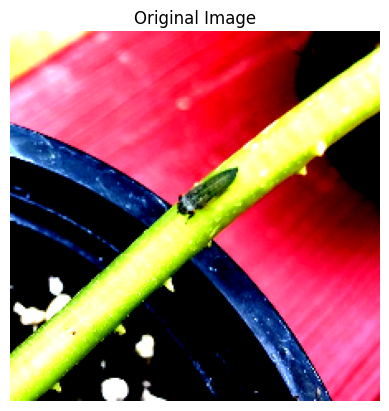

In [15]:
for image, label in dataloader:
    x = image[-1]

    #  # visualize the original image

    x = x.numpy().transpose(1, 2, 0)
    plt.imshow(x)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    break

    # plt.imshow(x[-1].cpu().numpy().astype(np.uint8).transpose(1, 2, 0))
    # plt.title("Original Image")
    # plt.axis("off")
    # plt.show()